# The Truck-Driver Problem

### Introduction
The truck-driver problem is a modification of the knapsack problem but applied to a real situation. The knapsack problem consist of doing a trade-off between weight and revenue aiming to maximize the second one.

### Problem Statement
A truck-driver is supoused to move certain amount of articles from one city to another. To do this he needs to determine which of them are more convenient (Lighter, cheaper to carry, etc.) in order to maximize revenue. This problem will not consider costs of transportation such as fuel, taxes, etc.
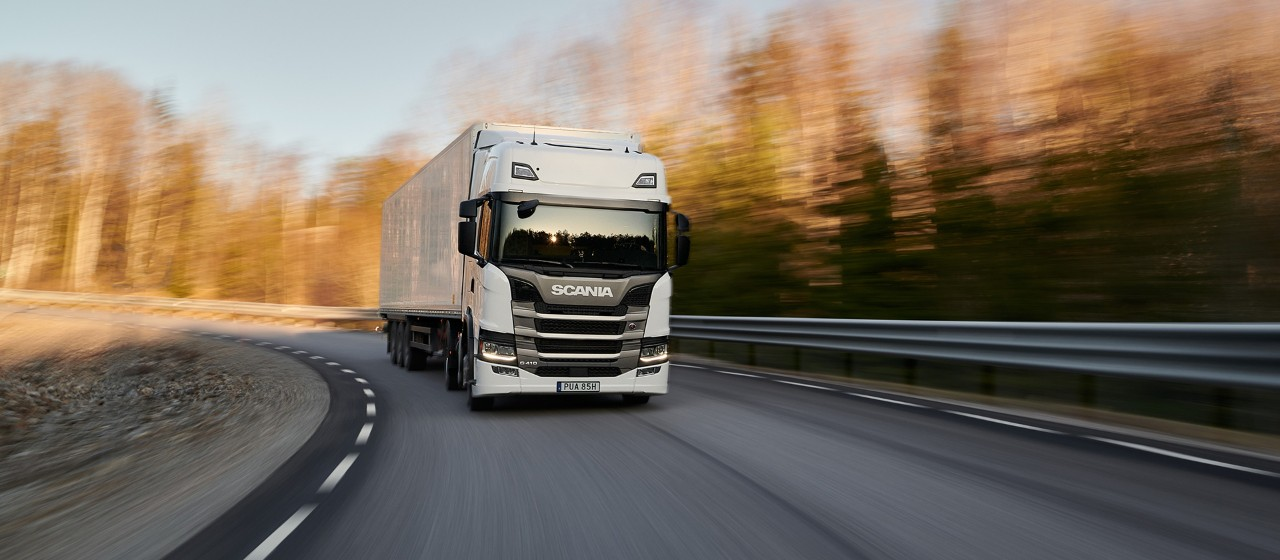

# Creating our Data
In order to solve this problem we need some data, as we don't have this kind of data avaliable this time we will create a dummy dataset which contains revenue in (pesos) and weigths in (kg) for different products. Some of these products are:
- Meat
- Eggs
- Fruits
- Soap
- MakeUp

etc. We will generate these data using a uniform distribution where weights and revenue will be bounded as follow:


- Weights will run from 20kg to 150kg
- Revenues will go from 800 pesos to 11,000 pesos

Have in mind the results obtained in this example are easily extrapolated to real data.

In [3]:
import pandas as pd
import numpy as np 

R_min = 800   # Min revenue ($Pesos)
R_max = 11000 # Max revenue ($Pesos)
w_min = 20.0  # Min weight (Kgs)
w_max = 150.0 # Max weight (Kgs)

# Truck-weight-capacity
twc = 2800

# Setting the random seed
np.random.seed(2022)

# Now we create the "product column" which will contain the list of products to be transported by the truck
product =['Meat','Eggs','Flour','Cans','Oils','Fruits','Vegetables','Soap','Detergent',
           'Toilet Paper', 'Clothes', 'MakeUp', 'Fragance', 'Shampoo', 'Television','Beans'
           'Dairy','Fritters','Sausages',]

N = len(product) # Number of transported products

# Then we create the "revenue column" where all this revenues will follow a uniform distribution
revenue = np.random.randint(R_min, R_max,N) 

# The column "number" is also usefull 
number = np.random.randint(1,5,N)

# Finally we create the "Weigth column" that is uniformelly distributed as well.
weights = np.random.randint(w_min, w_max,N) 


# We put all this column together to form the dataframe
df = pd.DataFrame({
    'Product':product,
    'Weight': weights,
    'Quantity':number,
    'Revenue': revenue}, 
    index = np.arange(1,len(product)+1))

df

,Product,Weight,Quantity,Revenue
1,Meat,142,1,5789
2,Eggs,142,3,2044
3,Flour,32,3,973
4,Cans,65,4,5520
5,Oils,110,3,7184
6,Fruits,96,2,8824
7,Vegetables,116,3,2866
8,Soap,33,1,824
9,Detergent,97,2,8277
10,Toilet Paper,72,4,9003


In [4]:
# The all products weight is:
print('The all pruducts-weight is:',sum(df.Weight*df.Quantity),'kg')
print('The truck-weight-capacity is',twc,'kg')

The all pruducts-weight is: 3487 kg
The truck-weight-capacity is 2800 kg


As the sum of all products-weights are higher than the truck-weight-capacity we'll need to decide which products we'll transport and which to reject. The previous situation can be stated as an optimization problem.

### The mathematical model for this problem is

$$
max\ \ \sum_i R_i\cdot n_i\cdot x_i
$$
$$
s.t.\ \ \sum_i w_i \cdot n_i\cdot x_i \leq w_{max}
$$
$$
x_i\geq 0
$$

Where $x_i$ represent de set of binary desicion variables we aim to optimize, it means we need to obtain which values of the variable **x** are 1 and which of them are 0. $R_i$ are the consecutive revenue values of the different dataset-products, $w_i$ the set of weigth of the products and $w_{max}$ the maximum capacity the truck can transport. 
- The first line represent the revenue maximization
- The second one the capacity weight restriction
- Last line indicate decision variables cannot take negative values

### In vector notation
We can also express the previous model in a vector way as:

$$
max\ \ R^T\cdot n\cdot x
$$
$$
s.t.\ \  w \cdot n^T \cdot x \leq w_{max}
$$
$$
x_i\geq 0
$$

**Let us create a model in the Pyomo environment**

1. We define the needed sets 
2. We initialize parameters
3. We define decision variables
4. We define constraings
5. We define the objective function
6. We solve the problem
7. Finally, we present results

In [26]:
from pyomo.environ import *

model = ConcreteModel()

# 1) We create the set to initialize both parameters and variables
model.N = RangeSet(len(df))

# 2) Initializing parameters
model.R = Param(model.N, initialize = df.Revenue )
model.W = Param(model.N, initialize = df.Weight )
model.Q = Param( model.N, initialize = df.Quantity)
model.MaxWeight = Param( initialize = twc )

# 3) Defining decision variables
model.x = Var(model.N, domain=Binary)

# 4) Stating the constraint:
model.C1 = Constraint( expr = sum(model.W[i] * model.Q[i] * model.x[i] for i in model.N) <= model.MaxWeight )

# 5) setting up the objective function
model.obj = Objective( expr = sum(model.R[i] * model.Q[i] * model.x[i] for i in model.N) , sense = maximize)

# 6) We call the solver
solver = SolverFactory('glpk')
solucion = solver.solve(model)

# 7) DISPLAYING RESULTS:
print('Solution:')
for i in model.N:
    print('x[',i,']=',value(model.x[i]))
    
print()
print('The products to be transported are:')
for i in model.N:
    if value(model.x[i]) == 1:
        print(df['Product'][i])

print()
print('The rejected products are:')
for i in model.N:
    if value(model.x[i]) == 0:
        print(df['Product'][i])

print()
print('The maximum revenue is:')
print('z=',value(model.obj)/1000,'hundred pesos')


TW = sum( model.W[i] * model.Q[i] * value(model.x[i]) for i in model.N)

print()
print('The accepted products weight is:')
print('weight=',TW,'kg')

print()
print('The transportation capacity is')
print('Max Capacity=',value(model.MaxWeight),'kg')

Solution:
x[ 1 ]= 1.0
x[ 2 ]= 0.0
x[ 3 ]= 1.0
x[ 4 ]= 1.0
x[ 5 ]= 1.0
x[ 6 ]= 1.0
x[ 7 ]= 1.0
x[ 8 ]= 1.0
x[ 9 ]= 1.0
x[ 10 ]= 1.0
x[ 11 ]= 1.0
x[ 12 ]= 1.0
x[ 13 ]= 1.0
x[ 14 ]= 0.0
x[ 15 ]= 1.0
x[ 16 ]= 1.0
x[ 17 ]= 1.0
x[ 18 ]= 1.0

The products to be transported are:
Meat
Flour
Cans
Oils
Fruits
Vegetables
Soap
Detergent
Toilet Paper
Clothes
MakeUp
Fragance
Television
BeansDairy
Fritters
Sausages

The rejected products are:
Eggs
Shampoo

The maximum revenue is:
z= 209.153 hundred pesos

The accepted products weight is:
weight= 2729.0 kg

The transportation capacity is
Max Capacity= 2800 kg


## Conclusion

We have been able to find an optimal solution to the truck-driver problem by doing a trade-off between weight and revenue for the different products to be transported. 

## Observations
- The least convenient products to be chosen are Eggs and Shampoo
- The maximum revenue reached was 209.153 hundred pesos
- The weight of the accepted products was 2,729kg which is lower than 2800, thus the solution is feasible.